### Configuração inicial

In [1]:
import pathlib
import sys

requirements_filename = 'requirements_ap3.txt'
if str(pathlib.Path().resolve().name) == "notebooks":
    root = str(pathlib.Path().resolve().parent.parent)+'/'
    sys.path.append(root)
    requirements_path = root + 'requirements/'+requirements_filename
else:
    ! git clone --branch ap3 https://github.com/Fabio-Trindade/Eng-Aprendizado-Maquina.git
    root = str(pathlib.Path().resolve())
    src_path = root + '/Eng-Aprendizado-Maquina/'
    requirements_path = src_path + 'requirements/'+requirements_filename
    sys.path.append(root + '/Eng-Aprendizado-Maquina/')

! pip install -r $requirements_path

### Imports

In [2]:
from src.utils.util_read_file import UtilReadFile
from src.constants.KPaths import KPaths
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from src.utils.util_pre_processor import UtilPreProcessor
from src.models.mlp import MLP
from torch import nn
import torch
from src.transforms.to_torch_tensor import NumpyToTorchTensor
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Análise exploratória (_Churn\_Bank.csv_)

A analise exploratória consiste de uma análise inicial dos dados com o objetivo de entender melhor os dados com que se está trabalhando. Esta análise permite que melhores decisões sejam tomadas ao implementar um modelo.

## O dataset

In [3]:
df = UtilReadFile.read_csv_with_pandas(KPaths.path_churn_bank)
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


A partir do dataframe acima percebe-se que:
* _RowNumber_ enumera cada linha, tornando-se um atributo que não traz informações relevantes.
* _CustomerId_ apresenta o ID de cada cliente. Se os IDs representam a ordem em que as pessoas se tornaram clientes da empresa então pode ser uma informação relevante, pois pode indicar que alguns clientes entraram em um período próximo e talvez a situação do banco em um determinado período pode ter influenciado a saída do cliente. Para estes dados, seria interessante analisar como os IDs se comportam em relação a coluna _Exited_.
* _Surname_ apresenta o sobrenome de cada cliente. Este atributo identifica cada cliente, portanto será desconsiderado como feature.
* _CreditScore_ representa o _score_ de cada cliente. Para esta coluna é importante realizar uma estatística descritiva e analisar possíveis transformações nos dados.
* _Geography_ e _Gender_ contém, respectivamente, o país e o gênero de cada cliente. Estes dados podem ser mapeados para valores numéricos ou utilizar one-hot encoding.
* _Age_ contém a idade de cada cliente. Pode ser benéfico analisar se há uma assimetria entre os dados e aplicar a técnica de _binning_.
* _Tenure_ representa a quantidade de tempo que a pessoa é cliente do banco. Aqui seria interessante realizar uma análise descritiva e analisar a necessidade de transformação dos dados. 
* _Exited_, _HasCrCard_ e _IsActiveMember_ contém valores True (1) e False (0) para indicar se é verdade ou não a informação da sua respectiva coluna.
* _NumOfProducts_: quantidade de produtos que cada cliente possui.
* _Balance_ e _EstimatedSalary_ representam, respectivamente, o saldo atual do cliente e o seu salário atual. Percebe-se que os valores destas colunas possuem valores muito discrepantes, havendo a necessidade de aplicar algum método de normalização.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Este dataset não possui dados nulos.

## Análise: _CustomerId_

In [6]:
def calc_percentage(df,columnx,columny,sort_column):
    n_exited = df[df[columny] == 0].sort_values(sort_column).reset_index()
    exited = df[df[columny] == 1].sort_values(sort_column).reset_index()
    assert(len(n_exited) == len(exited))
    
    return (n_exited[columnx] - exited[columnx])/(n_exited[columnx] + exited[columnx])

def calc_stats(df, bin_column,tgt_column,len_bins):
    min = df[bin_column].min()
    max = df[bin_column].max()
    aux = df[[bin_column,tgt_column]].copy()
    print((max - min + 1)/len_bins)

    bins = range(min,max + math.ceil((max - min + 1)/len_bins), math.ceil((max - min + 1)/len_bins))

    labels = [f'{i}-{i + (max - min + 1)/len_bins}' for i in range(min, max ,math.ceil((max - min + 1)/len_bins))]

    aux['Classe'] = pd.cut(aux[bin_column], bins=bins, labels=labels, right=False)

    aux = aux.groupby(by=[tgt_column,'Classe']).count().reset_index()

    return calc_percentage(aux,bin_column,tgt_column,'Classe')

In [7]:
len_bins = 100
temp_df = calc_stats(df,'CustomerId','Exited',len_bins)

count = 0
count2 = 0
for v in temp_df:
    if v >= 0.7:
        count+=1
    elif v <= -0.7:
        count2+=1
print(count,count2)

2499.9
8 0


/tmp/ipykernel_96369/343497872.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux = aux.groupby(by=[tgt_column,'Classe']).count().reset_index()


O código acima separa o ID dos clientes em 100 grupos, contendo no máximo 2500 IDs cada um, em ordem numérica. Para calcular se um determinado grupo tem uma tendência de continuar ou não no banco, foi utilizada a seguinte fórmula:
* (n_exited - exited)/(n_exited + exited).
    * n_exited: quantidade de clientes do grupo que não saíram do banco.
    * exited: quantidade de clientes do grupo que saíram do banco. 
Caso o valor seja maior ou igual a 0.7 então foi considerado que há uma tendência deste grupo em continuar no banco, e caso este valor seja menor ou igual a -0.7, foi considerado que este grupo tem uma forte tendência em sair do banco. 

Foi encontrado que 8 dos 100 grupos tem uma forte tendência em continuar no banco, enquanto nenhum grupo tem uma forte tendência em sair. Como não foi encontrado um resultado relevante, este atributo será desconsiderado para o modelo.

## Análise: _Credit Score_

In [8]:
df['CreditScore'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

Aqui é possível analisar se há uma relação entre o _score_ e a saída do cliente. Para isso, será considerada a seguinte classificação:
* Baixo score: primeiro quartil;
* Médio score: segundo e terceiro quartil;
* Alto score: último quartil. 

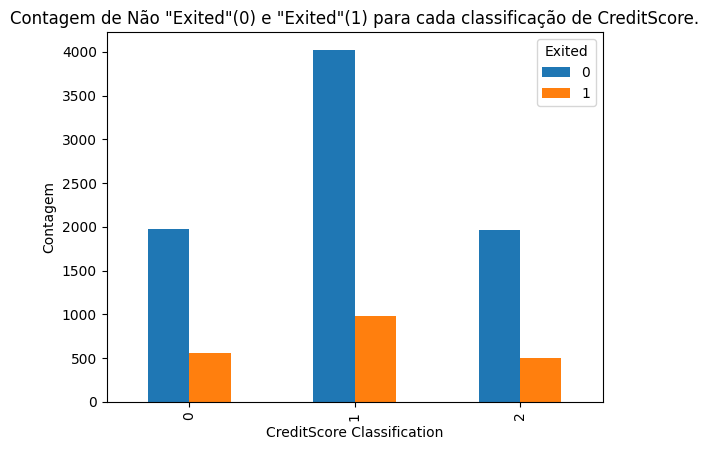

In [9]:
temp_df = df[['Exited','CreditScore']].copy()
temp_df.loc[temp_df['CreditScore'] <= 584,'CreditScore'] = 0
temp_df.loc[(temp_df['CreditScore'] > 584) & (temp_df['CreditScore'] <= 718),'CreditScore'] = 1
temp_df.loc[temp_df['CreditScore'] > 718, 'CreditScore'] = 2

count = temp_df.pivot_table(index='CreditScore', columns='Exited', aggfunc='size', fill_value=0)


count.plot(kind='bar')
plt.xlabel('CreditScore Classification')
plt.ylabel('Contagem')
plt.title('Contagem de Não "Exited"(0) e "Exited"(1) para cada classificação de CreditScore.')
plt.legend(title='Exited')
plt.show()


Separar os scores em 3 categorias mostrou que não há uma diferença entre pessoas de diferentes scores e a saída do banco. Por ex., pessoas com menor score não tem uma tendência maior de sair do banco do que com os scores maiores, e vice-versa. 

<Axes: title={'center': 'CreditScore'}, xlabel='Exited'>

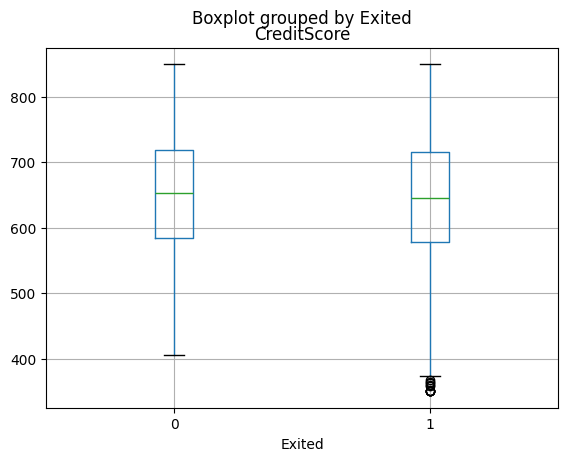

In [10]:
df.boxplot('CreditScore',by='Exited')

De acordo com o boxplot, acima não há uma relação bem definida entre o score da pessoa e a saída ao banco. Para este atributo seria interessante aplicar apenas a normalização.

## Análise: _NumOfProducts_

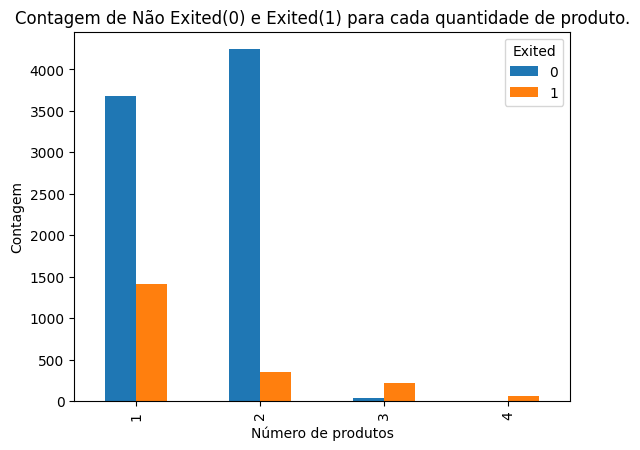

In [11]:
count_yz = df.pivot_table(index='NumOfProducts', columns='Exited', aggfunc='size', fill_value=0)


count_yz.plot(kind='bar')
plt.xlabel('Número de produtos')
plt.ylabel('Contagem')
plt.title('Contagem de Não Exited(0) e Exited(1) para cada quantidade de produto.')
plt.legend(title='Exited')
plt.show()

De acordo com o gráfico acima, há uma tendência de pessoas com maior quantidade de produtos deixarem o banco.

## Análise: _Age_

<Axes: >

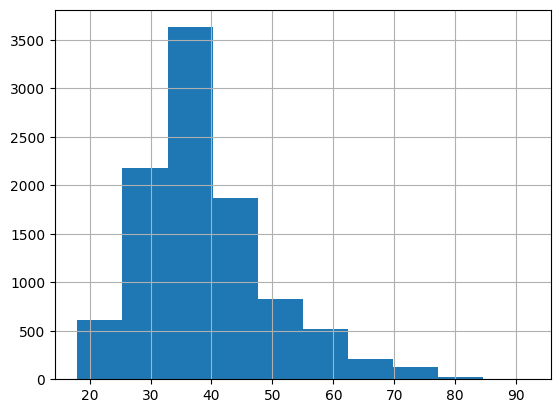

In [12]:
df['Age'].hist()

O histograma acima mostra uma assimetria entre os dados, portanto será aplicada uma técnica de __binning__ posteriormente.

<Axes: title={'center': 'Age'}, xlabel='Exited'>

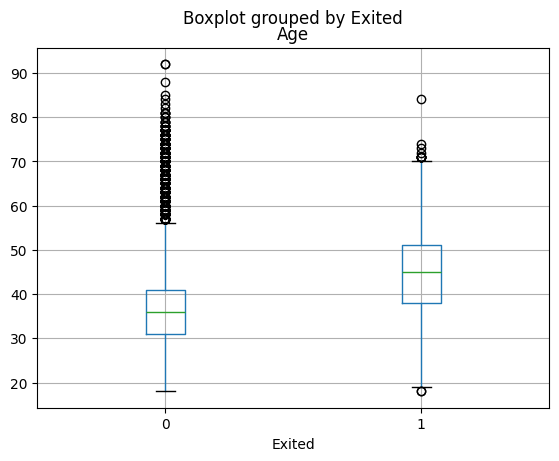

In [13]:
df.boxplot('Age',by='Exited')

De acordo com os gráficos acima, podemos inferir que o modelo pode se beneficiar de uma técnica de _binning_, uma vez que há uma assimetria no histograma e é mais comum pessoas mais velhas saírem do banco do que não saírem.

## Análise: __Tenure__

In [14]:
df['Tenure'].describe()

count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64

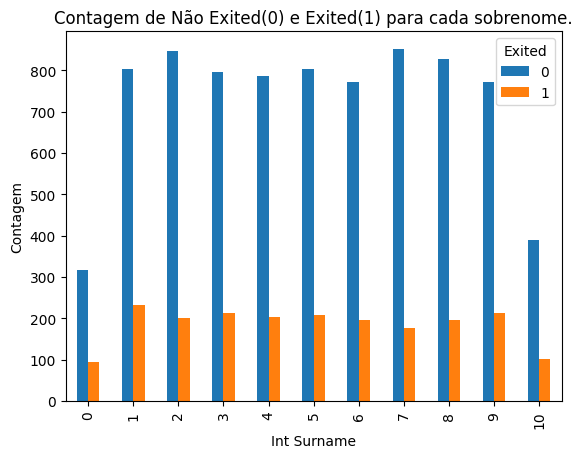

In [15]:
count_yz = df.pivot_table(index='Tenure', columns='Exited', aggfunc='size', fill_value=0)

count_yz.plot(kind='bar')
plt.xlabel('Int Surname')
plt.ylabel('Contagem')
plt.title('Contagem de Não Exited(0) e Exited(1) para cada sobrenome.')
plt.legend(title='Exited')
plt.show()

<Axes: title={'center': 'Tenure'}, xlabel='Exited'>

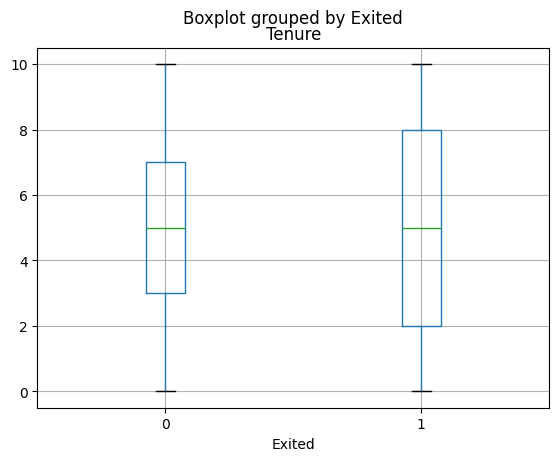

In [16]:
df.boxplot('Tenure',by='Exited')

O atributo _Tenure_ sozinho não parece influenciar a saída da pessoa do banco.

## Análise: Correlação entre os atributos 

In [17]:
df[list(set(df.columns) - set(['Surname','Gender','Geography']))].corr()

,CustomerId,Balance,Age,Tenure,CreditScore,EstimatedSalary,RowNumber,HasCrCard,IsActiveMember,Exited,NumOfProducts
CustomerId,1.000000,-0.012419,0.009497,-0.014883,0.005308,0.015271,0.004202,-0.014025,0.001665,-0.006248,0.016972
Balance,-0.012419,1.000000,0.028308,-0.012254,0.006268,0.012797,-0.009067,-0.014858,-0.010084,0.118533,-0.304180
Age,0.009497,0.028308,1.000000,-0.009997,-0.003965,-0.007201,0.000783,-0.011721,0.085472,0.285323,-0.030680
Tenure,-0.014883,-0.012254,-0.009997,1.000000,0.000842,0.007784,-0.006495,0.022583,-0.028362,-0.014001,0.013444
CreditScore,0.005308,0.006268,-0.003965,0.000842,1.000000,-0.001384,0.005840,-0.005458,0.025651,-0.027094,0.012238
EstimatedSalary,0.015271,0.012797,-0.007201,0.007784,-0.001384,1.000000,-0.005988,-0.009933,-0.011421,0.012097,0.014204
RowNumber,0.004202,-0.009067,0.000783,-0.006495,0.005840,-0.005988,1.000000,0.000599,0.012044,-0.016571,0.007246
HasCrCard,-0.014025,-0.014858,-0.011721,0.022583,-0.005458,-0.009933,0.000599,1.000000,-0.011866,-0.007138,0.003183
IsActiveMember,0.001665,-0.010084,0.085472,-0.028362,0.025651,-0.011421,0.012044,-0.011866,1.000000,-0.156128,0.009612
Exited,-0.006248,0.118533,0.285323,-0.014001,-0.027094,0.012097,-0.016571,-0.007138,-0.156128,1.000000,-0.047820


Os atributos sozinhos não mostram ter uma forte correlação com a saída de um cliente ao banco, mas talvez em conjunto sejam informações que auxiliem bem a prever se um cliente deixará o banco ou não.

## Prevendo a coluna _Exited_ (sem engenharia de atributos)

Para predizer a coluna _Exited_ será utilizada uma rede neural MLP (_Multi Layer Perceptron_). A implementação do modelo pode ser vista abaixo:

```python
class MLP(nn.Module):
    def __init__(self, dim_layers: list,dtype=float):
        super().__init__()
        self.len_layers = len(dim_layers)
        self.linears = nn.ModuleList([])
        for i in range(self.len_layers - 1):
            self.linears.append(nn.Linear(dim_layers[i],dim_layers[i + 1],dtype=dtype))
            nn.init.xavier_uniform_(self.linears[len(self.linears) - 1].weight)
            nn.init.constant_(self.linears[len(self.linears) -1 ].bias, 0.0) 
    
    def forward(self, features):
        x = self.linears[0](features)
        for linear in self.linears[1:]:
            x = linear(x)
        return x
```

## Preparação dos dados

In [18]:
feature_columns = ['CreditScore', 'Geography',
        'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
        'IsActiveMember', 'EstimatedSalary']
feature_columns

['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [19]:
target_column = ['Exited']
target_column

['Exited']

### Separação em dados de treino, validação e teste

In [20]:
df_train, df_test = train_test_split(df[feature_columns + target_column], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, random_state=42)
df_train = df_train.reset_index().drop('index',axis=1)
df_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,718,France,Female,41,1,0.00,2,0,1,27509.52,1
1,465,France,Male,25,2,78247.31,2,1,1,10472.31,0
2,631,France,Male,35,8,129205.49,1,1,1,79146.36,0
3,373,France,Male,42,7,0.00,1,1,0,77786.37,1
4,624,Germany,Female,27,7,104848.68,1,1,1,167387.36,0
...,...,...,...,...,...,...,...,...,...,...,...
7645,586,Germany,Female,56,9,100781.75,2,1,1,54448.41,0
7646,788,France,Male,55,3,0.00,1,0,1,13288.46,1
7647,534,France,Male,36,4,120037.96,1,1,0,36275.94,0
7648,549,Germany,Male,54,5,92877.33,1,1,0,2619.64,1


In [21]:
df_test = df_test.reset_index().drop('index',axis=1)
df_test

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,596,Germany,Male,32,3,96709.07,2,0,0,41788.37,0
1,623,France,Male,43,1,0.00,2,1,1,146379.30,0
2,601,Spain,Female,44,4,0.00,2,1,0,58561.31,0
3,506,Germany,Male,59,8,119152.10,2,1,1,170679.74,0
4,560,Spain,Female,27,7,124995.98,1,1,1,114669.79,0
...,...,...,...,...,...,...,...,...,...,...,...
995,567,France,Male,59,3,0.00,2,1,0,25843.70,1
996,636,France,Male,34,8,0.00,2,1,0,38570.13,0
997,690,France,Female,26,3,118097.87,1,1,0,61257.83,0
998,452,Spain,Male,44,3,88915.85,1,1,0,69697.74,0


In [22]:
df_val = df_val.reset_index().drop('index',axis=1)
df_val

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,757,France,Male,36,7,144852.06,1,0,0,130861.95,0
1,552,France,Male,29,10,0.00,2,1,0,12186.83,0
2,619,France,Female,30,7,70729.17,1,1,1,160948.87,0
3,633,France,Male,35,10,0.00,2,1,0,65675.47,0
4,698,Spain,Male,38,10,95010.92,1,1,1,105227.86,0
...,...,...,...,...,...,...,...,...,...,...,...
1345,820,Spain,Female,31,2,94222.53,1,1,0,103570.80,0
1346,714,Spain,Male,45,0,124693.48,1,0,1,187194.15,0
1347,534,France,Male,52,1,0.00,3,1,1,104035.41,1
1348,609,France,Male,37,1,39344.83,1,1,1,178291.89,1


### Separando os dados categóricos

In [23]:
categorical_columns = ['Geography', 'Gender']

### Separando os dados numéricos

In [24]:
numeric_columns = list(set(feature_columns) - set(categorical_columns))
numeric_columns

['Balance',
 'Age',
 'Tenure',
 'CreditScore',
 'EstimatedSalary',
 'HasCrCard',
 'IsActiveMember',
 'NumOfProducts']

### Transformação dos dados categóricos

In [25]:
vocabs = {}
for column in categorical_columns:
    vocabs[column] = UtilPreProcessor.creat_vocab(df_train[column])[0]
    for i in range(len(df_train)):
        df_train.loc[i,column] = UtilPreProcessor.get_index_vocab(vocabs[column],df_train.loc[i,column])
    
    for i in range(len(df_test)):
        
        df_test.loc[i,column] = UtilPreProcessor.get_index_vocab(vocabs[column],df.loc[i,column])
    
    for i in range(len(df_val)):
        df_val.loc[i,column] = UtilPreProcessor.get_index_vocab(vocabs[column],df_val.loc[i,column])
    
df_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,718,0,0,41,1,0.00,2,0,1,27509.52,1
1,465,0,1,25,2,78247.31,2,1,1,10472.31,0
2,631,0,1,35,8,129205.49,1,1,1,79146.36,0
3,373,0,1,42,7,0.00,1,1,0,77786.37,1
4,624,1,0,27,7,104848.68,1,1,1,167387.36,0
...,...,...,...,...,...,...,...,...,...,...,...
7645,586,1,0,56,9,100781.75,2,1,1,54448.41,0
7646,788,0,1,55,3,0.00,1,0,1,13288.46,1
7647,534,0,1,36,4,120037.96,1,1,0,36275.94,0
7648,549,1,1,54,5,92877.33,1,1,0,2619.64,1


In [26]:
df_test

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,596,0,0,32,3,96709.07,2,0,0,41788.37,0
1,623,2,0,43,1,0.00,2,1,1,146379.30,0
2,601,0,0,44,4,0.00,2,1,0,58561.31,0
3,506,0,0,59,8,119152.10,2,1,1,170679.74,0
4,560,2,0,27,7,124995.98,1,1,1,114669.79,0
...,...,...,...,...,...,...,...,...,...,...,...
995,567,2,1,59,3,0.00,2,1,0,25843.70,1
996,636,2,1,34,8,0.00,2,1,0,38570.13,0
997,690,2,1,26,3,118097.87,1,1,0,61257.83,0
998,452,1,0,44,3,88915.85,1,1,0,69697.74,0


In [27]:
df_val

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,757,0,1,36,7,144852.06,1,0,0,130861.95,0
1,552,0,1,29,10,0.00,2,1,0,12186.83,0
2,619,0,0,30,7,70729.17,1,1,1,160948.87,0
3,633,0,1,35,10,0.00,2,1,0,65675.47,0
4,698,2,1,38,10,95010.92,1,1,1,105227.86,0
...,...,...,...,...,...,...,...,...,...,...,...
1345,820,2,0,31,2,94222.53,1,1,0,103570.80,0
1346,714,2,1,45,0,124693.48,1,0,1,187194.15,0
1347,534,0,1,52,1,0.00,3,1,1,104035.41,1
1348,609,0,1,37,1,39344.83,1,1,1,178291.89,1


### Transformando os dados numéricos
Treinar um modelo de rede neural com valores altos como os valores numéricos pode causar instabilidade nos resultados. Por isso, será feita uma transformação simples nas colunas RowNumber, CustomerId, Balance e EstimatedSalary, normalizando cada coluna pelo seu valor máximo.

In [28]:
for column in ['Balance' , 'EstimatedSalary','CreditScore','Age']:
    for df in [df_train,df_test,df_val]:
        max_n = df[column].max()
        df[column] = df[column]/max_n
df_train


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.844706,0,0,0.445652,1,0.000000,2,0,1,0.137568,1
1,0.547059,0,1,0.271739,2,0.311869,2,1,1,0.052369,0
2,0.742353,0,1,0.380435,8,0.514972,1,1,1,0.395790,0
3,0.438824,0,1,0.456522,7,0.000000,1,1,0,0.388989,1
4,0.734118,1,0,0.293478,7,0.417893,1,1,1,0.837059,0
...,...,...,...,...,...,...,...,...,...,...,...
7645,0.689412,1,0,0.608696,9,0.401684,2,1,1,0.272282,0
7646,0.927059,0,1,0.597826,3,0.000000,1,0,1,0.066452,1
7647,0.628235,0,1,0.391304,4,0.478433,1,1,0,0.181406,0
7648,0.645882,1,1,0.586957,5,0.370180,1,1,0,0.013100,1


### Criando o modelo

In [29]:
class MyModel(nn.Module):
    def __init__(self,dim_layers,dtype=float):
        super().__init__()
        self.mlp = MLP(dim_layers,dtype=dtype)
        
    def forward(self,features):
        x = self.mlp(features)
        return torch.nn.functional.sigmoid(x)


In [30]:
dim_in = len(feature_columns)
dim_out = len(target_column)
model = MyModel([dim_in,32,32,dim_out])
optim = torch.optim.Adam(model.parameters(),0.001)
loss_fn = torch.nn.BCELoss()

### Definindo hyperparâmetros

In [31]:
epochs = 10
batch_size = 4

### Criando datasets de treino, validação e teste

```python
class DfDataset(Dataset):
    def __init__(self, df_features, df_labels, transform = None):
        self.x = df_features.values
        self.y = df_labels.values
        self.transform = transform
        self.len = len(self.x)

    def __getitem__(self,index):
        if self.transform:
            return self.transform(self.x[index]),self.transform(self.y[index])
        return self.x[index],self.y[index]

    def __len__(self):
        return self.len

```

In [32]:
from torch.utils.data import DataLoader
from src.datasets.df_dataset import DfDataset

dataset = DfDataset(df_train[feature_columns],df_train[target_column],transform=NumpyToTorchTensor(float))
val_dataset = DfDataset(df_val[feature_columns],df_val[target_column],transform=NumpyToTorchTensor(float))
test_dataset = DfDataset(df_test[feature_columns],df_test[target_column],transform=NumpyToTorchTensor(float))

dataloader = DataLoader(dataset,batch_size, shuffle=True, num_workers=2)

### Treinamento

```python
class UtilTrain:
    @staticmethod
    def train(model,optim,loss_fn,features,labels):
        optim.zero_grad()
        predictions = model(features)
        loss = loss_fn(predictions,labels)
        loss.backward()
        optim.step()
        return loss.detach()
    
    def train_epochs(epochs,dataloader,val_dataset,model,optim,loss_fn):
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            count = 0
            for features, target in dataloader:
                loss = UtilTrain.train(model,optim,loss_fn,features,target)
                total_loss += loss
                count+=1
            prec,acc = UtilTrain.eval(model,val_dataset)
            print(f"epoch {epoch + 1} - loss = {total_loss/count} - val_precision = {prec:.2f} - val_acc = {acc:.2f}")
    
    def eval(model,dataset):
        model.eval()
        features, targets = dataset[:]
        predictions = model(features)
        for i in range(len(predictions.detach().numpy().ravel())):
            predictions[i] = 1 if predictions[i] > 0.5 else 0
        prec = precision_score(targets.detach().numpy().ravel(), predictions.detach().numpy().ravel(),  zero_division='warn')
        acc = accuracy_score(targets.detach().numpy().ravel(),predictions.detach().numpy().ravel())
        return prec,acc
```

In [33]:
from src.utils.util_train import UtilTrain

UtilTrain.train_epochs(epochs,dataloader,val_dataset,model,optim,loss_fn)

epoch 1 - loss = 0.48643527132937564 - val_precision = 0.76 - val_acc = 0.79
epoch 2 - loss = 0.46004428149816917 - val_precision = 0.57 - val_acc = 0.80
epoch 3 - loss = 0.44784988507213325 - val_precision = 0.60 - val_acc = 0.80
epoch 4 - loss = 0.44592525260671056 - val_precision = 0.50 - val_acc = 0.78
epoch 5 - loss = 0.4452498905649216 - val_precision = 0.48 - val_acc = 0.77
epoch 6 - loss = 0.44436969896868994 - val_precision = 0.56 - val_acc = 0.79
epoch 7 - loss = 0.4438530368035499 - val_precision = 0.46 - val_acc = 0.76
epoch 8 - loss = 0.4426590787369724 - val_precision = 0.48 - val_acc = 0.77
epoch 9 - loss = 0.44262208223507693 - val_precision = 0.51 - val_acc = 0.78
epoch 10 - loss = 0.44179770678100183 - val_precision = 0.50 - val_acc = 0.78


### Avaliando os dados de teste

In [34]:
prec,acc = UtilTrain.eval(model,test_dataset)
print(f'precision = {prec:.2f} - acc = {acc:.2f}')

precision = 0.52 - acc = 0.81


A partir dos resultados acima vimos que o modelo não obteve uma boa precisão ao utilizar os dados sem as devidas transformações. Na proxima seção será aplicada uma engenharia de atributos para transformar os dados de acordo com as discussões realizadas na seção de análise exploratória.

## Engenharia de atributos - Dados Numéricos

Nesta seção são aplicados métodos de transformações nos dados numéricos e analisado se este processamento melhora o resultado do modelo.

### Carregandos os dados

In [35]:
df = UtilReadFile.read_csv_with_pandas(KPaths.path_churn_bank)
df

df_train, df_test = train_test_split(df[feature_columns + target_column], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, random_state=42)
df_train = df_train.reset_index().drop('index',axis=1)
df_test = df_test.reset_index().drop('index',axis=1)
df_val = df_val.reset_index().drop('index',axis=1)

df_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,718,France,Female,41,1,0.00,2,0,1,27509.52,1
1,465,France,Male,25,2,78247.31,2,1,1,10472.31,0
2,631,France,Male,35,8,129205.49,1,1,1,79146.36,0
3,373,France,Male,42,7,0.00,1,1,0,77786.37,1
4,624,Germany,Female,27,7,104848.68,1,1,1,167387.36,0
...,...,...,...,...,...,...,...,...,...,...,...
7645,586,Germany,Female,56,9,100781.75,2,1,1,54448.41,0
7646,788,France,Male,55,3,0.00,1,0,1,13288.46,1
7647,534,France,Male,36,4,120037.96,1,1,0,36275.94,0
7648,549,Germany,Male,54,5,92877.33,1,1,0,2619.64,1


### Normalização dos dados

In [36]:
scaler = MinMaxScaler()
columns_to_scale = ["CreditScore", "Age", "Balance",'EstimatedSalary']
scaler.fit(df_train[columns_to_scale])

for dff in [df_train,df_test,df_val]:
    dff[columns_to_scale] = scaler.transform(dff[columns_to_scale])
df_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.736,France,Female,0.310811,1,0.000000,2,0,1,0.137179,1
1,0.230,France,Male,0.094595,2,0.311869,2,1,1,0.051942,0
2,0.562,France,Male,0.229730,8,0.514972,1,1,1,0.395517,0
3,0.046,France,Male,0.324324,7,0.000000,1,1,0,0.388713,1
4,0.548,Germany,Female,0.121622,7,0.417893,1,1,1,0.836986,0
...,...,...,...,...,...,...,...,...,...,...,...
7645,0.472,Germany,Female,0.513514,9,0.401684,2,1,1,0.271954,0
7646,0.876,France,Male,0.500000,3,0.000000,1,0,1,0.066031,1
7647,0.368,France,Male,0.243243,4,0.478433,1,1,0,0.181037,0
7648,0.398,Germany,Male,0.486486,5,0.370180,1,1,0,0.012655,1


### Transformação dos dados categóricos

In [37]:
vocabs = {}
for column in categorical_columns:
    vocabs[column] = UtilPreProcessor.creat_vocab(df_train[column])[0]
    for i in range(len(df_train)):
        df_train.loc[i,column] = UtilPreProcessor.get_index_vocab(vocabs[column],df_train.loc[i,column])
    
    for i in range(len(df_test)):
        
        df_test.loc[i,column] = UtilPreProcessor.get_index_vocab(vocabs[column],df.loc[i,column])
    
    for i in range(len(df_val)):
        df_val.loc[i,column] = UtilPreProcessor.get_index_vocab(vocabs[column],df_val.loc[i,column])
    
df_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.736,0,0,0.310811,1,0.000000,2,0,1,0.137179,1
1,0.230,0,1,0.094595,2,0.311869,2,1,1,0.051942,0
2,0.562,0,1,0.229730,8,0.514972,1,1,1,0.395517,0
3,0.046,0,1,0.324324,7,0.000000,1,1,0,0.388713,1
4,0.548,1,0,0.121622,7,0.417893,1,1,1,0.836986,0
...,...,...,...,...,...,...,...,...,...,...,...
7645,0.472,1,0,0.513514,9,0.401684,2,1,1,0.271954,0
7646,0.876,0,1,0.500000,3,0.000000,1,0,1,0.066031,1
7647,0.368,0,1,0.243243,4,0.478433,1,1,0,0.181037,0
7648,0.398,1,1,0.486486,5,0.370180,1,1,0,0.012655,1


### Treinamento do modelo

In [38]:
model = MyModel([dim_in,32,32,dim_out])
optim = torch.optim.Adam(model.parameters(),0.001)
loss_fn = nn.BCELoss()

In [39]:
dataset = DfDataset(df_train[feature_columns],df_train[target_column],transform=NumpyToTorchTensor(float))

val_dataset = DfDataset(df_val[feature_columns],df_val[target_column],transform=NumpyToTorchTensor(float))

test_dataset = DfDataset(df_test[feature_columns],df_test[target_column],transform=NumpyToTorchTensor(float))


dataloader = DataLoader(dataset,batch_size, shuffle=True, num_workers=2)

In [40]:
from src.utils.util_train import UtilTrain

UtilTrain.train_epochs(epochs,dataloader,val_dataset,model,optim,loss_fn)

epoch 1 - loss = 0.48471314829870904 - val_precision = 0.73 - val_acc = 0.80
epoch 2 - loss = 0.45272066534471883 - val_precision = 0.57 - val_acc = 0.79
epoch 3 - loss = 0.4479603876323146 - val_precision = 0.54 - val_acc = 0.79
epoch 4 - loss = 0.4462871299133448 - val_precision = 0.62 - val_acc = 0.80
epoch 5 - loss = 0.44407176043159363 - val_precision = 0.71 - val_acc = 0.79
epoch 6 - loss = 0.44456640405969716 - val_precision = 0.78 - val_acc = 0.79
epoch 7 - loss = 0.4416685814077835 - val_precision = 0.74 - val_acc = 0.80
epoch 8 - loss = 0.4426351622066908 - val_precision = 0.57 - val_acc = 0.79
epoch 9 - loss = 0.44159246236771765 - val_precision = 0.68 - val_acc = 0.80
epoch 10 - loss = 0.4404772658993408 - val_precision = 0.59 - val_acc = 0.80


In [41]:
prec,acc = UtilTrain.eval(model,test_dataset)
print(f'precision = {prec:.2f} - acc = {prec:.2f}')

precision = 0.59 - acc = 0.59


Apenas normalizar os dados aumentou a precisão do modelo, no entanto, a acurácia diminuiu. 

## Engenharia de atributos - Novas transformações nos dados

### Binning da idade

In [42]:
bins = [0,26,56,76,100]

new_df = df[list((feature_columns)+(target_column))].copy()
new_df['Age'] = pd.cut(new_df['Age'], bins=bins, labels=False)
new_df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,1,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,1,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,1,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,1,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,1,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,1,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,1,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,1,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,1,3,75075.31,2,1,0,92888.52,1


### One-Hot encoding: países

In [43]:
new_df = pd.get_dummies(new_df,
columns=categorical_columns)


In [44]:
feature_columns = list(set(new_df.columns) - set(['Exited']))
feature_columns

['Geography_Spain',
 'Gender_Female',
 'Gender_Male',
 'Balance',
 'Age',
 'Tenure',
 'CreditScore',
 'EstimatedSalary',
 'Geography_France',
 'Geography_Germany',
 'HasCrCard',
 'IsActiveMember',
 'NumOfProducts']

### Testanto modelo com os novos dados

In [45]:
df_train, df_test = train_test_split(new_df, test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, random_state=42)
df_train = df_train.reset_index().drop('index',axis=1)
df_test = df_test.reset_index().drop('index',axis=1)
df_val = df_val.reset_index().drop('index',axis=1)

dim_in = len(feature_columns)
dim_out = len(target_column)

### Normalização

In [46]:
scaler = MinMaxScaler()
columns_to_scale = ["CreditScore", "Balance",'EstimatedSalary']
scaler.fit(df_train[columns_to_scale])

for dff in [df_train,df_test,df_val]:
    dff[columns_to_scale] = scaler.transform(dff[columns_to_scale])
df_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.736,1,1,0.000000,2,0,1,0.137179,1,True,False,False,True,False
1,0.230,0,2,0.311869,2,1,1,0.051942,0,True,False,False,False,True
2,0.562,1,8,0.514972,1,1,1,0.395517,0,True,False,False,False,True
3,0.046,1,7,0.000000,1,1,0,0.388713,1,True,False,False,False,True
4,0.548,1,7,0.417893,1,1,1,0.836986,0,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7645,0.472,1,9,0.401684,2,1,1,0.271954,0,False,True,False,True,False
7646,0.876,1,3,0.000000,1,0,1,0.066031,1,True,False,False,False,True
7647,0.368,1,4,0.478433,1,1,0,0.181037,0,True,False,False,False,True
7648,0.398,1,5,0.370180,1,1,0,0.012655,1,False,True,False,False,True


### Criação do modelo

In [47]:
dim_in = len(feature_columns)
model = MyModel([dim_in,32,32,dim_out])
optim = torch.optim.Adam(model.parameters(),0.001)
loss_fn = nn.BCELoss()

### Criação dos datasets

In [48]:
dataset = DfDataset(df_train[feature_columns],df_train[target_column],transform=NumpyToTorchTensor(float))

val_dataset = DfDataset(df_val[feature_columns],df_val[target_column],transform=NumpyToTorchTensor(float))

test_dataset = DfDataset(df_test[feature_columns],df_test[target_column],transform=NumpyToTorchTensor(float))

dataloader = DataLoader(dataset,batch_size, shuffle=True, num_workers=2)


### Treinamento e valiadação

In [49]:
UtilTrain.train_epochs(epochs,dataloader,val_dataset,model,optim,loss_fn)

epoch 1 - loss = 0.4840881201198507 - val_precision = 1.00 - val_acc = 0.78
epoch 2 - loss = 0.47421666804679447 - val_precision = 0.66 - val_acc = 0.79
epoch 3 - loss = 0.47062144243125453 - val_precision = 0.64 - val_acc = 0.79
epoch 4 - loss = 0.46848741570793473 - val_precision = 0.58 - val_acc = 0.79
epoch 5 - loss = 0.46661720280458313 - val_precision = 0.71 - val_acc = 0.79
epoch 6 - loss = 0.46642525343619995 - val_precision = 0.67 - val_acc = 0.80
epoch 7 - loss = 0.4662451323298623 - val_precision = 0.81 - val_acc = 0.79
epoch 8 - loss = 0.4653448705740438 - val_precision = 1.00 - val_acc = 0.79
epoch 9 - loss = 0.4657420885579633 - val_precision = 0.93 - val_acc = 0.79
epoch 10 - loss = 0.46589077259465017 - val_precision = 0.77 - val_acc = 0.79


In [50]:
prec, acc = UtilTrain.eval(model,test_dataset)
print(f'precision {prec:.2f} - acc = {acc:.2f}')

precision 0.51 - acc = 0.81


Realizar mais transformações melhorou apenas a acurácia do modelo, enquanto a precisão diminuiu. Diferentes resultados são obtidos ao executar este notebook diversas vezes, visto que os dados de treino e teste serão separados em conjuntos diferentes. Em alguns conjuntos a engenharia de atributos leva o modelo a tomar decisões melhores.

## Análise exploratória _heart_csv_

In [51]:
df = UtilReadFile.read_csv_with_pandas(KPaths.path_heart_csv)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [53]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


A partir das descrições acima, percebe-se facilmente que as colunas _ca_, _cp_, _slope_ e _thal_ podem ser transformada em one-hot enconding para gerar mais features, enquanto as colunas _trestbps_, _chol_ devem ser normalizadas.

### Análise: Age 

<Axes: >

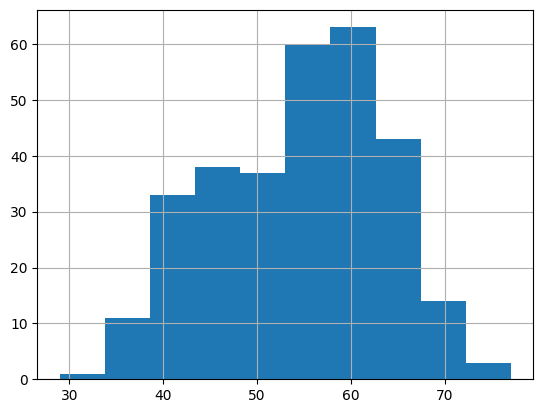

In [54]:
df['age'].hist()

<Axes: title={'center': 'age'}, xlabel='target'>

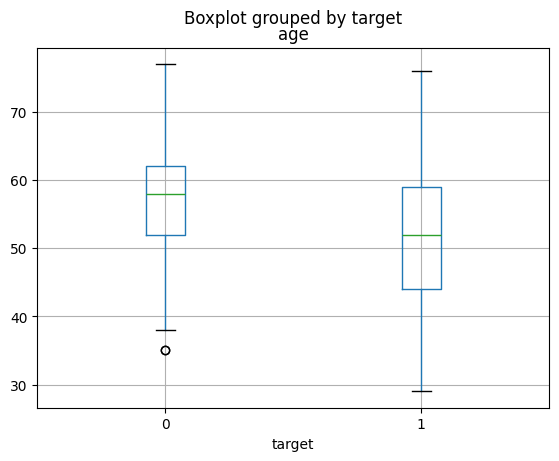

In [55]:
df.boxplot('age',by='target')

De acordo com o boxplot, pessoas mais novas (entre 28 e 38 anos aproximadamente) tendem a possuir valor target 1. Neste atributo será aplicado uma técnica de _binning_.

### Analisando a correlação

In [56]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


Este dataset apresenta mais atributos correlacionados com a coluna alvo do que o dataset anterior. Possivelmente os resultados obtidos serão melhores.

## Preparação dos dados

In [57]:
feature_columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']
target_column = ['target']


In [58]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, random_state=42)
df_train = df_train.reset_index().drop('index',axis=1)
df_test = df_test.reset_index().drop('index',axis=1)
df_val = df_val.reset_index().drop('index',axis=1)

dim_in = len(feature_columns)
dim_out = len(target_column)
df_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,35,1,1,122,192,0,1,174,0,0.0,2,0,2,1
1,60,1,0,130,206,0,0,132,1,2.4,1,2,3,0
2,48,1,0,130,256,1,0,150,1,0.0,2,2,3,0
3,65,1,0,120,177,0,1,140,0,0.4,2,0,3,1
4,55,0,1,132,342,0,1,166,0,1.2,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,49,1,2,118,149,0,0,126,0,0.8,2,3,2,0
227,47,1,0,112,204,0,1,143,0,0.1,2,0,2,1
228,56,1,3,120,193,0,0,162,0,1.9,1,0,3,1
229,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0


### Criando o modelo

In [59]:
model = MyModel([dim_in,32,32,dim_out])
optim = torch.optim.Adam(model.parameters(),0.001)

### Criando os datasets

In [60]:
dataset = DfDataset(df_train[feature_columns],df_train[target_column],transform=NumpyToTorchTensor(float))

val_dataset = DfDataset(df_val[feature_columns],df_val[target_column],transform=NumpyToTorchTensor(float))

test_dataset = DfDataset(df_test[feature_columns],df_test[target_column],transform=NumpyToTorchTensor(float))

dataloader = DataLoader(dataset,batch_size, shuffle=True, num_workers=2)

## Treinamento e validação

In [61]:
UtilTrain.train_epochs(epochs,dataloader,val_dataset,model,optim,loss_fn)

epoch 1 - loss = 7.6730032717351575 - val_precision = 0.65 - val_acc = 0.68
epoch 2 - loss = 4.287100864709301 - val_precision = 0.64 - val_acc = 0.61


epoch 3 - loss = 2.559217373107084 - val_precision = 0.65 - val_acc = 0.68
epoch 4 - loss = 2.072818403926013 - val_precision = 0.78 - val_acc = 0.66
epoch 5 - loss = 2.16560980889027 - val_precision = 0.71 - val_acc = 0.71
epoch 6 - loss = 1.4848071781734449 - val_precision = 0.69 - val_acc = 0.73
epoch 7 - loss = 1.7340373545306607 - val_precision = 0.69 - val_acc = 0.73
epoch 8 - loss = 0.8983174225927374 - val_precision = 0.88 - val_acc = 0.71
epoch 9 - loss = 1.5471026776426025 - val_precision = 0.69 - val_acc = 0.73
epoch 10 - loss = 1.0328005594146277 - val_precision = 0.86 - val_acc = 0.78


In [62]:
prec, acc = UtilTrain.eval(model,test_dataset)
print(f'precision = {prec:.2f} - acc = {acc}')

precision = 1.00 - acc = 0.8064516129032258


Apesar do modelo não ter excelentes resultados nos dados de treinamento, ele foi capaz de conseguir uma ótima precisão nos dados de teste.

## Treinamento e validação - Transformação apenas dos dados numéricos

In [63]:
scaler = MinMaxScaler()
columns_to_scale = ['trestbps','chol','thalach']

scaler.fit(df_train[columns_to_scale])

for dff in [df_train,df_test,df_val]:
    dff[columns_to_scale] = scaler.transform(dff[columns_to_scale])
df_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,35,1,1,0.285714,0.140878,0,1,0.754386,0,0.0,2,0,2,1
1,60,1,0,0.367347,0.173210,0,0,0.385965,1,2.4,1,2,3,0
2,48,1,0,0.367347,0.288684,1,0,0.543860,1,0.0,2,2,3,0
3,65,1,0,0.265306,0.106236,0,1,0.456140,0,0.4,2,0,3,1
4,55,0,1,0.387755,0.487298,0,1,0.684211,0,1.2,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,49,1,2,0.244898,0.041570,0,0,0.333333,0,0.8,2,3,2,0
227,47,1,0,0.183673,0.168591,0,1,0.482456,0,0.1,2,0,2,1
228,56,1,3,0.265306,0.143187,0,0,0.649123,0,1.9,1,0,3,1
229,46,1,0,0.265306,0.272517,0,0,0.491228,0,0.8,2,0,3,0


In [64]:
model = MyModel([dim_in,32,32,dim_out])
optim = torch.optim.Adam(model.parameters(),0.001)
dataset = DfDataset(df_train[feature_columns],df_train[target_column],transform=NumpyToTorchTensor(float))

val_dataset = DfDataset(df_val[feature_columns],df_val[target_column],transform=NumpyToTorchTensor(float))

test_dataset = DfDataset(df_test[feature_columns],df_test[target_column],transform=NumpyToTorchTensor(float))


dataloader = DataLoader(dataset,batch_size, shuffle=True, num_workers=2)

UtilTrain.train_epochs(epochs,dataloader,val_dataset,model,optim,loss_fn)

epoch 1 - loss = 4.132900084495614 - val_precision = 0.00 - val_acc = 0.41


/home/fabio/venvs/my_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


epoch 2 - loss = 0.7307823696792126 - val_precision = 0.70 - val_acc = 0.71
epoch 3 - loss = 0.5134869701847071 - val_precision = 0.72 - val_acc = 0.73
epoch 4 - loss = 0.4706422301524155 - val_precision = 1.00 - val_acc = 0.83
epoch 5 - loss = 0.5306189570137534 - val_precision = 0.72 - val_acc = 0.76
epoch 6 - loss = 0.577653477305786 - val_precision = 0.75 - val_acc = 0.76
epoch 7 - loss = 0.45489862201263415 - val_precision = 0.72 - val_acc = 0.73
epoch 8 - loss = 0.4813920621909441 - val_precision = 0.72 - val_acc = 0.76
epoch 9 - loss = 0.41045868069596964 - val_precision = 0.78 - val_acc = 0.78
epoch 10 - loss = 0.39436188472072314 - val_precision = 0.75 - val_acc = 0.76


In [65]:
prec, acc = UtilTrain.eval(model,test_dataset)
print(f'precision = {prec:.2f} - acc = {acc}')

precision = 0.78 - acc = 0.7741935483870968


Transformar os dados, para este conjunto de dados de treino, valdiação e teste, levou o modelo a tomar decisões piores.

## Realizando novas transformações

### One-hot encoding

In [66]:
categorical_columns = ['cp','ca','slope','thal']
df = pd.get_dummies(df,
columns=categorical_columns)
df


,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,target,...,ca_2,ca_3,ca_4,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,63,1,145,233,1,0,150,0,2.3,1,...,False,False,False,True,False,False,False,True,False,False
1,37,1,130,250,0,1,187,0,3.5,1,...,False,False,False,True,False,False,False,False,True,False
2,41,0,130,204,0,0,172,0,1.4,1,...,False,False,False,False,False,True,False,False,True,False
3,56,1,120,236,0,1,178,0,0.8,1,...,False,False,False,False,False,True,False,False,True,False
4,57,0,120,354,0,1,163,1,0.6,1,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,1,123,1,0.2,0,...,False,False,False,False,True,False,False,False,False,True
299,45,1,110,264,0,1,132,0,1.2,0,...,False,False,False,False,True,False,False,False,False,True
300,68,1,144,193,1,1,141,0,3.4,0,...,True,False,False,False,True,False,False,False,False,True
301,57,1,130,131,0,1,115,1,1.2,0,...,False,False,False,False,True,False,False,False,False,True


In [67]:
feature_columns = list(set(df.columns) - set(['target']))
feature_columns

['exang',
 'trestbps',
 'slope_2',
 'age',
 'ca_0',
 'ca_2',
 'thal_1',
 'thalach',
 'cp_0',
 'fbs',
 'cp_2',
 'cp_1',
 'thal_0',
 'restecg',
 'oldpeak',
 'sex',
 'ca_4',
 'thal_2',
 'chol',
 'cp_3',
 'slope_0',
 'ca_1',
 'slope_1',
 'thal_3',
 'ca_3']

### Binning: idade

In [68]:
bins = [0,27,39,56,76,100]

df['age'] = pd.cut(df['age'], bins=bins, labels=False)
df

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,target,...,ca_2,ca_3,ca_4,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,3,1,145,233,1,0,150,0,2.3,1,...,False,False,False,True,False,False,False,True,False,False
1,1,1,130,250,0,1,187,0,3.5,1,...,False,False,False,True,False,False,False,False,True,False
2,2,0,130,204,0,0,172,0,1.4,1,...,False,False,False,False,False,True,False,False,True,False
3,2,1,120,236,0,1,178,0,0.8,1,...,False,False,False,False,False,True,False,False,True,False
4,3,0,120,354,0,1,163,1,0.6,1,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,3,0,140,241,0,1,123,1,0.2,0,...,False,False,False,False,True,False,False,False,False,True
299,2,1,110,264,0,1,132,0,1.2,0,...,False,False,False,False,True,False,False,False,False,True
300,3,1,144,193,1,1,141,0,3.4,0,...,True,False,False,False,True,False,False,False,False,True
301,3,1,130,131,0,1,115,1,1.2,0,...,False,False,False,False,True,False,False,False,False,True


### Preparação dos dados para treinamento

In [69]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.15, random_state=42)
df_train = df_train.reset_index().drop('index',axis=1)
df_test = df_test.reset_index().drop('index',axis=1)
df_val = df_val.reset_index().drop('index',axis=1)

dim_in = len(feature_columns)
dim_out = len(target_column)
df_train


,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,target,...,ca_2,ca_3,ca_4,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,1,1,122,192,0,1,174,0,0.0,1,...,False,False,False,False,False,True,False,False,True,False
1,3,1,130,206,0,0,132,1,2.4,0,...,True,False,False,False,True,False,False,False,False,True
2,2,1,130,256,1,0,150,1,0.0,0,...,True,False,False,False,False,True,False,False,False,True
3,3,1,120,177,0,1,140,0,0.4,1,...,False,False,False,False,False,True,False,False,False,True
4,2,0,132,342,0,1,166,0,1.2,1,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,2,1,118,149,0,0,126,0,0.8,0,...,False,True,False,False,False,True,False,False,True,False
227,2,1,112,204,0,1,143,0,0.1,1,...,False,False,False,False,False,True,False,False,True,False
228,2,1,120,193,0,0,162,0,1.9,1,...,False,False,False,False,True,False,False,False,False,True
229,2,1,120,249,0,0,144,0,0.8,0,...,False,False,False,False,False,True,False,False,False,True


### Normalização dos dados

In [70]:
scaler = MinMaxScaler()
columns_to_scale = ['trestbps','chol','thalach']

scaler.fit(df_train[columns_to_scale])

for dff in [df_train,df_test,df_val]:
    dff[columns_to_scale] = scaler.transform(dff[columns_to_scale])
df_train

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,target,...,ca_2,ca_3,ca_4,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,1,1,0.285714,0.140878,0,1,0.754386,0,0.0,1,...,False,False,False,False,False,True,False,False,True,False
1,3,1,0.367347,0.173210,0,0,0.385965,1,2.4,0,...,True,False,False,False,True,False,False,False,False,True
2,2,1,0.367347,0.288684,1,0,0.543860,1,0.0,0,...,True,False,False,False,False,True,False,False,False,True
3,3,1,0.265306,0.106236,0,1,0.456140,0,0.4,1,...,False,False,False,False,False,True,False,False,False,True
4,2,0,0.387755,0.487298,0,1,0.684211,0,1.2,1,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,2,1,0.244898,0.041570,0,0,0.333333,0,0.8,0,...,False,True,False,False,False,True,False,False,True,False
227,2,1,0.183673,0.168591,0,1,0.482456,0,0.1,1,...,False,False,False,False,False,True,False,False,True,False
228,2,1,0.265306,0.143187,0,0,0.649123,0,1.9,1,...,False,False,False,False,True,False,False,False,False,True
229,2,1,0.265306,0.272517,0,0,0.491228,0,0.8,0,...,False,False,False,False,False,True,False,False,False,True


## Treinamento e validação com as transformações

In [71]:
model = MyModel([dim_in,32,32,dim_out])
optim = torch.optim.Adam(model.parameters(),0.001)
dataset = DfDataset(df_train[feature_columns],df_train[target_column],transform=NumpyToTorchTensor(float))

val_dataset = DfDataset(df_val[feature_columns],df_val[target_column],transform=NumpyToTorchTensor(float))

test_dataset = DfDataset(df_test[feature_columns],df_test[target_column],transform=NumpyToTorchTensor(float))


dataloader = DataLoader(dataset,batch_size, shuffle=True, num_workers=2)

UtilTrain.train_epochs(epochs,dataloader,val_dataset,model,optim,loss_fn)


epoch 1 - loss = 0.6862297861934337 - val_precision = 0.85 - val_acc = 0.85
epoch 2 - loss = 0.4552158083721631 - val_precision = 0.88 - val_acc = 0.90


epoch 3 - loss = 0.3896637811981522 - val_precision = 0.92 - val_acc = 0.90
epoch 4 - loss = 0.35149598678106975 - val_precision = 0.92 - val_acc = 0.90
epoch 5 - loss = 0.35102783609103616 - val_precision = 0.92 - val_acc = 0.90
epoch 6 - loss = 0.3348067553422574 - val_precision = 0.88 - val_acc = 0.88
epoch 7 - loss = 0.32454321024003363 - val_precision = 0.88 - val_acc = 0.90
epoch 8 - loss = 0.31388246172274564 - val_precision = 0.92 - val_acc = 0.90
epoch 9 - loss = 0.31637661598614497 - val_precision = 0.96 - val_acc = 0.93
epoch 10 - loss = 0.32120829669296685 - val_precision = 0.88 - val_acc = 0.88


In [72]:
prec, acc = UtilTrain.eval(model,test_dataset)
print(f'precision = {prec:.2f} - acc = {acc}')

precision = 0.79 - acc = 0.8064516129032258


## Conclusão

Através deste notebook vimos empiricamente como a engenharia de atributos pode ajudar um modelo a tomar decisões melhores e, consequentemente, gerar melhores resultados. No entanto, vimos também que as vezes, utilizar atributos sem aplicações de técnicas de transformações dos dados pode ser capaz de levar o modelo a tomar ótimas decisões. Além disso, os resultados acima podem ser melhorados aplicando-se técnicas de regularização para diminuir o overfitting e variando os hyperparâmetros.